In [1]:
cd ../

/wk171/ytkuo/TCRI_reanalysis


In [2]:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [3]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)
from modules.data_handler import ascii_array_to_string
import pandas as pd
import numpy as np
from tqdm import tqdm

2023-04-15 00:49:15.054297: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
# fet experiment settings from yaml file
from modules.experiment_helper import parse_experiment_settings

experiment_path = 'experiments/caa.yml'
experiment_settings = parse_experiment_settings(experiment_path)

In [5]:
# load dataset
from modules.data_handler import get_tensorflow_datasets

datasets = get_tensorflow_datasets(**experiment_settings['data'])

2023-04-15 00:49:16.491331: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-15 00:49:16.562472: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-15 00:49:16.562499: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ubuntu
2023-04-15 00:49:16.562505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ubuntu
2023-04-15 00:49:16.562594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.39.0
2023-04-15 00:49:16.562612: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.39.0
2023-04-15 00:49:16.562617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.39.0
2023-04-15 00:49:16.563310: I tensorflow/core/platform/cpu_feature_gua

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [6]:
# load trained model
from modules.model_constructor import create_model_by_experiment_path

model = create_model_by_experiment_path(experiment_path, version='best-MSE')

saved_models/caa/best-MSE


In [7]:
df = pd.DataFrame(columns=['now','24h_Vmax', 'pred_24h_Vmax', 'starting_frame'])
for image_sequences, labels, feature,frame_ID_ascii, dV in tqdm(datasets['test']):
    starting_frame = list(map(ascii_array_to_string, frame_ID_ascii.numpy()))
    pred = np.squeeze(model(image_sequences, feature).numpy())
    V24 = labels.numpy()
    now = V24 - dV.numpy()
    batch_size = pred.shape[0]
    for i in range(batch_size):
        df.loc[df.shape[0]] = [now[i], V24[i], pred[i], starting_frame[i]]

0it [00:00, ?it/s]2023-04-15 00:49:17.339313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-15 00:49:17.339801: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199915000 Hz
2023-04-15 00:49:17.351079: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1653] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
194it [00:28,  6.91it/s]


In [8]:
df = df.sort_values(['starting_frame']).reset_index(drop=True).round(2)

In [9]:
df.head(5)

,now,24h_Vmax,pred_24h_Vmax,starting_frame
0,25.0,38.0,42.92,201901E_2019062515
1,25.0,40.0,44.44,201901E_2019062518
2,28.0,43.0,50.74,201901E_2019062521
3,30.0,45.0,51.31,201901E_2019062600
4,30.0,48.0,47.94,201901E_2019062603


In [10]:
(abs(df.pred_24h_Vmax- df['24h_Vmax'])).mean()

9.316541477507224

In [ ]:
(abs(df.pred_24h_Vmax- df.now)).mean()

In [11]:
df.to_csv('./saved_csv/caa_encode_together_deep_deep_max.csv', index = False)

In [7]:
import matplotlib.pyplot as plt

In [8]:
for image_sequences, labels, feature,frame_ID_ascii, dV in datasets['test']:
    break

2023-04-13 16:46:25.769778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-13 16:46:25.788672: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199915000 Hz
2023-04-13 16:46:25.799923: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1653] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


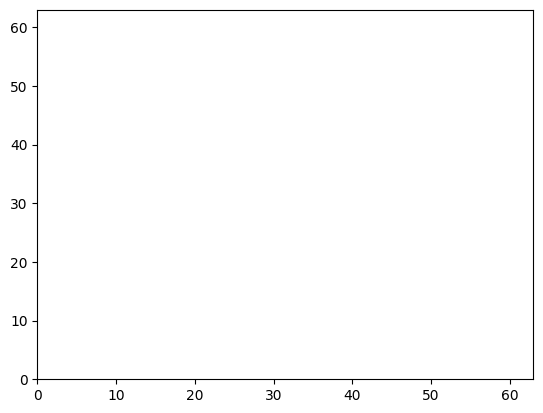

In [9]:
tmp = image_sequences[:,0,:,:,0]
tmp = np.nanmean(tmp, axis = 0)
plt.contourf(tmp, levels=np.linspace(200,280))

In [35]:
import h5py
df = pd.read_hdf('/bk2/ytkuo/TCSA/TCRI_reanalysis.h5', key='info', mode='r')
df['TC_spd'] = df['TC_spd'].fillna(method='bfill')
df['TC_dir'] = df['TC_dir'].fillna(method='bfill')

In [20]:
df[df.TC_ID == '202026W'].tail(15)

,TC_ID,datetime,basin,Vmax,TC_lon,TC_lat,V_BT,V_PF,R34_PF,AM_PF,...,TPW,T200,RH700,RH850,VOR850,U200,VWSdir,VWSmag,LMFrot,LMFmag
88436,202026W,2020122318,WPAC,20.0,105.4,7.9,20.0,18.338669,NaN,2270.244734,...,53.34,220.38,73.93,83.64,0.02e-06,-12.01,104,8.15,332,4.23
88437,202026W,2020122321,WPAC,20.0,104.7,7.8,20.0,18.405603,NaN,2351.931432,...,53.08,220.23,74.83,84.59,0.44e-06,-12.28,105,8.47,336,4.16
88438,202026W,2020122400,WPAC,20.0,104.0,7.6,20.0,21.147440,NaN,2651.717445,...,53.13,220.35,74.93,84.91,1.18e-06,-14.06,113,10.73,337,4.21
88439,202026W,2020122403,WPAC,23.0,103.4,7.7,23.0,17.626160,NaN,2295.050021,...,53.50,220.47,76.52,85.64,1.51e-06,-14.47,120,11.51,339,4.50
88440,202026W,2020122406,WPAC,25.0,102.8,7.7,25.0,18.361067,NaN,2364.159207,...,53.94,220.55,78.18,86.08,1.53e-06,-13.24,122,11.02,342,4.07
88441,202026W,2020122409,WPAC,28.0,102.3,7.9,28.0,18.903439,NaN,2404.745103,...,53.83,220.64,77.54,85.38,1.64e-06,-11.18,131,9.28,331,4.31
88442,202026W,2020122412,WPAC,30.0,101.8,8.1,30.0,19.366930,NaN,2364.824312,...,53.67,220.70,75.89,84.29,2.39e-06,-10.17,142,7.86,317,5.41
88443,202026W,2020122415,WPAC,28.0,101.3,8.3,28.0,19.140620,NaN,2351.416712,...,53.99,220.48,76.71,84.95,2.41e-06,-9.58,146,6.59,313,6.02
88444,202026W,2020122418,WPAC,25.0,100.9,8.4,25.0,19.302713,NaN,2427.761924,...,54.11,220.26,78.56,86.03,2.41e-06,-8.33,156,5.13,307,6.45
88445,202026W,2020122421,WPAC,23.0,100.3,9.1,23.0,20.295542,NaN,2391.340022,...,53.46,220.14,81.54,87.00,1.62e-06,-7.40,171,4.31,288,6.85


In [39]:
df.iloc[88439+6:88440+25,15:30]

,delta_V_6h,delta_R_6h,delta_V_12h,delta_R_12h,delta_V_24h,delta_R_24h,TC_spd,TC_dir,SST,POT,TPW,T200,RH700,RH850,VOR850
88445,-5.0,NaN,-5.0,NaN,3.0,NaN,25.875441,300.451206,28.11,107.75,53.46,220.14,81.54,87.00,1.62e-06
88446,-5.0,NaN,-10.0,NaN,0.0,NaN,26.439470,304.457653,27.82,104.23,52.38,220.29,79.26,85.31,1.15e-06
88447,-3.0,NaN,-8.0,NaN,-3.0,NaN,NaN,NaN,28.11,107.75,52.11,220.24,76.02,83.67,0.68e-06
88448,0.0,NaN,-5.0,NaN,-5.0,NaN,NaN,NaN,28.42,111.73,51.59,220.28,72.94,82.31,-0.03e-06
88449,-2.0,NaN,-5.0,NaN,-10.0,NaN,NaN,NaN,28.47,112.39,50.78,220.38,70.94,81.68,-1.84e-06
88450,-5.0,NaN,-5.0,NaN,-15.0,NaN,NaN,NaN,28.53,113.19,49.83,220.42,69.19,79.74,-3.97e-06
